# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
plt.style.use('fivethirtyeight')

# Read the CSV into DataFrame

In [4]:
# Load the data
file_path = Path('Resources/lending_data.csv')
df = pd.read_csv(file_path)
df.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


In [5]:
# create dataframe to store all the report outcomes for final analysis
keys = ["avg_iba","avg_rec","avg_geo","avg_f1"]
df_model_analysis = pd.DataFrame(columns = ["Model","avg_iba","avg_rec","avg_geo","avg_f1"]).set_index("Model")

# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.drop(columns='loan_status')
X = pd.get_dummies(X)

# Create our target
y = df[["loan_status"]].copy()

In [7]:
X.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,homeowner_mortgage,homeowner_own,homeowner_rent
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.497472,0.398911,0.103616
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.499997,0.489678,0.304764
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000,0.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000,0.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,1.000000,1.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000,1.000000,1.000000


In [8]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     75036
high_risk     2500
Name: loan_status, dtype: int64

In [9]:
# Create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Simple Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [14]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.9889115309798473

In [15]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
cm

array([[  609,    10],
       [  113, 18652]], dtype=int64)

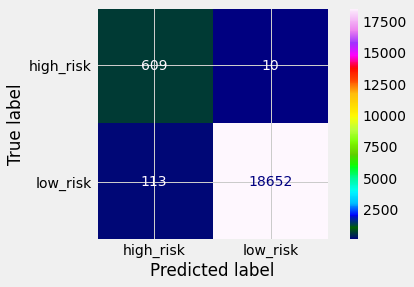

In [16]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap="gist_ncar");

In [17]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.98      0.99      0.91      0.99      0.98       619
   low_risk       1.00      0.99      0.98      1.00      0.99      0.98     18765

avg / total       0.99      0.99      0.98      0.99      0.99      0.98     19384



In [18]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "Simple Logistic"
df_model_analysis = df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"))


# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [19]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ran_over_sample = RandomOverSampler(random_state=1)
X_ov_resamp, y_ov_resamp = ran_over_sample.fit_resample(X_train_scaled, y_train)

# View the count of target classes with Counter
Counter(y_ov_resamp)

Counter({'loan_status': 1})

In [20]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_ov_resamp, y_ov_resamp)

LogisticRegression(random_state=1)

In [21]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_bal_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_bal_pred)

0.9934649587814939

In [22]:
# Display the confusion matrix
cm= confusion_matrix(y_test, y_bal_pred)
cm

array([[  615,     4],
       [  124, 18641]], dtype=int64)

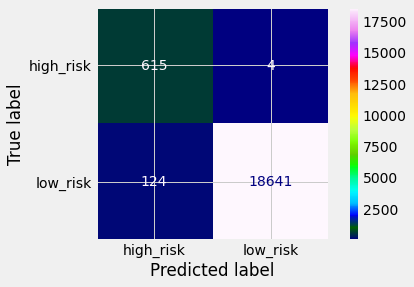

In [23]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap="gist_ncar");

In [24]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_bal_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



In [25]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_bal_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "Over Sampling"
df_model_analysis= df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"),ignore_index=False)

### SMOTE Oversampling

In [26]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_sm_resamp, y_sm_resamp = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(X_train_scaled, y_train)
from collections import Counter

# View the count of target classes with Counter
Counter(y_sm_resamp)

Counter({'loan_status': 1})

In [27]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_sm_resamp, y_sm_resamp)

LogisticRegression(random_state=1)

In [28]:
# Calculated the balanced accuracy score
y_log_re_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_log_re_pred)

0.9934649587814939

In [29]:
# Display the confusion matrix
confusion_matrix(y_test, y_log_re_pred)

array([[  615,     4],
       [  124, 18641]], dtype=int64)

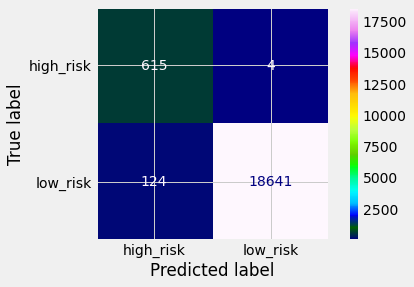

In [30]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap="gist_ncar");

In [31]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_log_re_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



In [32]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_log_re_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "SMOTE Sampling"
df_model_analysis= df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"),ignore_index=False)

# Undersampling

In this section, you will test an undersampling algorithm to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [33]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids
cluster_centroids = ClusterCentroids(random_state=1)
X_cc_resampled, y_cc_resampled = cluster_centroids.fit_resample(X_train_scaled, y_train)
# View the count of target classes with Counter
Counter(y_cc_resampled)

Counter({'loan_status': 1})

In [34]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_cc_resampled, y_cc_resampled)

LogisticRegression(random_state=1)

In [35]:
# Calculate the balanced accuracy score
y_cc_lr_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_cc_lr_pred)

0.9929503031930944

In [36]:
# Display the confusion matrix
cm=confusion_matrix(y_test, y_cc_lr_pred)
cm

array([[  614,     5],
       [  113, 18652]], dtype=int64)

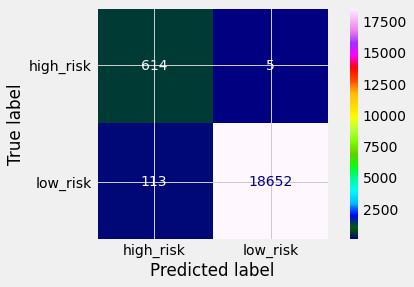

In [37]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_,)
disp.plot(cmap="gist_ncar");

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_cc_lr_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.84      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



In [39]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_cc_lr_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "Undersampling"
df_model_analysis= df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"),ignore_index=False)

In [40]:
df_model_analysis

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Simple Logistic,0.978848,0.993655,0.988899,0.99389
Over Sampling,0.986959,0.993397,0.993465,0.993678
SMOTE Sampling,0.986959,0.993397,0.993465,0.993678
Undersampling,0.986139,0.993913,0.99295,0.994148


# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [41]:
# Resample the training data with SMOTEENN

from imblearn.combine import SMOTEENN
smot_enn = SMOTEENN(random_state=1)
X_smote_resamp, y_smote_resam = smot_enn.fit_resample(X_train_scaled, y_train)

# View the count of target classes with Counter
Counter(y_smote_resam)

Counter({'loan_status': 1})

In [42]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_smote_resamp, y_smote_resam)

LogisticRegression(random_state=1)

In [43]:
# Calculate the balanced accuracy score
y_smote_lr_pred = model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_smote_lr_pred)

0.9934649587814939

In [44]:
# Display the confusion matrix
cm=confusion_matrix(y_test, y_smote_lr_pred)
cm

array([[  615,     4],
       [  124, 18641]], dtype=int64)

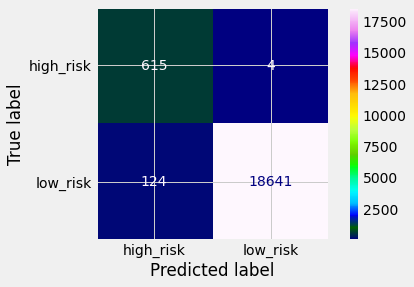

In [45]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot(cmap="gist_ncar");

In [46]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_smote_lr_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.83      0.99      0.99      0.91      0.99      0.99       619
   low_risk       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



In [47]:
# adding report information to a data frame for analysis
#get report in dictionary
report = classification_report_imbalanced(y_test, y_smote_lr_pred,output_dict=True)
report_extract = { key: report[key] for key in keys }
report_extract["Model"] = "Combined"
df_model_analysis= df_model_analysis.append(pd.DataFrame.from_dict(report_extract,orient="index").T.set_index("Model"),ignore_index=False)

## Analysis

In [48]:
#cummulative analysis
df_model_analysis

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Simple Logistic,0.978848,0.993655,0.988899,0.99389
Over Sampling,0.986959,0.993397,0.993465,0.993678
SMOTE Sampling,0.986959,0.993397,0.993465,0.993678
Undersampling,0.986139,0.993913,0.99295,0.994148
Combined,0.986959,0.993397,0.993465,0.993678


In [49]:
# order by balanced accuracy
df_model_analysis.sort_values(by="avg_iba",ascending=False)

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Over Sampling,0.986959,0.993397,0.993465,0.993678
SMOTE Sampling,0.986959,0.993397,0.993465,0.993678
Combined,0.986959,0.993397,0.993465,0.993678
Undersampling,0.986139,0.993913,0.99295,0.994148
Simple Logistic,0.978848,0.993655,0.988899,0.99389


In [50]:
# order by recall
df_model_analysis.sort_values(by="avg_rec",ascending=False)

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Undersampling,0.986139,0.993913,0.99295,0.994148
Simple Logistic,0.978848,0.993655,0.988899,0.99389
Over Sampling,0.986959,0.993397,0.993465,0.993678
SMOTE Sampling,0.986959,0.993397,0.993465,0.993678
Combined,0.986959,0.993397,0.993465,0.993678


In [51]:
# order by geometric mean 
df_model_analysis.sort_values(by="avg_geo",ascending=False)

,avg_iba,avg_rec,avg_geo,avg_f1
Model,,,,
Over Sampling,0.986959,0.993397,0.993465,0.993678
SMOTE Sampling,0.986959,0.993397,0.993465,0.993678
Combined,0.986959,0.993397,0.993465,0.993678
Undersampling,0.986139,0.993913,0.99295,0.994148
Simple Logistic,0.978848,0.993655,0.988899,0.99389


# Final Questions

1. Which model had the best balanced accuracy score?

   Over sampling, SMOTE sampling and Combibed Sampling Performed best with a balanced accuracy score of 0.986959

2. Which model had the best recall score?

   Under sampling performed best with a recall score of 0.993913. Simply printing the classification report shows the values rounded off to two decimal places but extration of the complete metric show that thi model performs slightly better.

3. Which model had the best geometric mean score?

    Over sampling, SMOTE sampling and Combibed Sampling Performed best with a geometric mean score of 0.993465

Reference : Scikit:The best value is 1 and the worst value is 0. 


### Export output for readme images

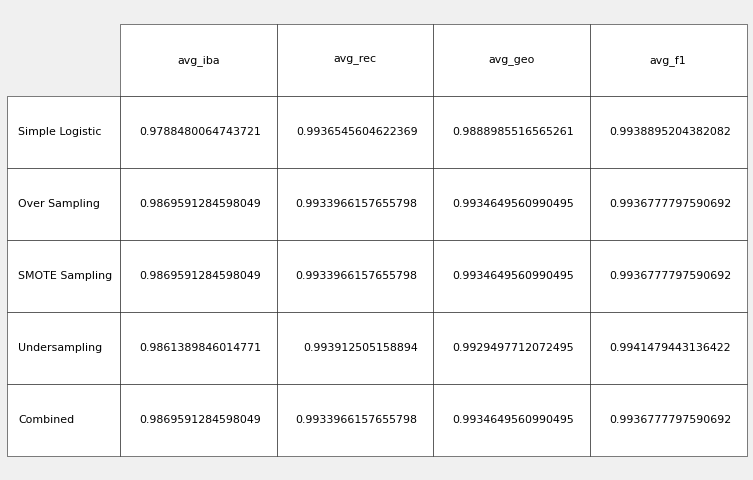

In [55]:
from pandas.plotting import table 
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ret_table = table(ax, df_model_analysis,loc="center");
ret_table.set_fontsize(44)
ret_table.scale(1,6)
ax.axis('off');
plt.savefig('../Images/summary_resampling.jpg')